<a href="https://colab.research.google.com/github/AAhmadS/NLP-HW3/blob/main/Copy_of_Copy_of_Copy_of_NLP_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and import packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/TasnimDataset/

/content/drive/MyDrive/TasnimDataset


In [3]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install transformers
! pip install arabic-reshaper
! pip install python-bidi
# ! pip install hazm
! pip install dadmatools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-g1ouszi8
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-g1ouszi8
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=a55bf6031e9fb6c8b56740aabdd9ce562897e5c179e71bc3c591958bb267d967
  Stored in directory: /tmp/pip-ephem-wheel-cache-u71g2dwa/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [4]:
# ! mkdir fonts

In [5]:
from __future__ import unicode_literals
# from hazm import Normalizer as hNormalizer
# from dadmatools.models.normalizer import Normalizer as dNormalizer
import gc
import time
import copy
import PIL
import torch
import os
# import dill
import clip
import requests
import pandas as pd
import numpy as np
from PIL import Image
import torch.nn as nn
import multiprocessing
from tqdm import tqdm
from io import BytesIO
import matplotlib.pyplot as plt
from pkg_resources import packaging
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from matplotlib.font_manager import FontProperties
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from torch.cuda.amp import autocast
from sklearn.model_selection import train_test_split
from transformers import CLIPModel, CLIPConfig, CLIPVisionModel, CLIPFeatureExtractor
from transformers import AutoModel, AutoTokenizer, AutoModel, TFAutoModel, AutoConfig
from transformers import BertModel
from transformers import TrainingArguments, Trainer, RobertaModel
from transformers import default_data_collator
from IPython.display import clear_output
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter

# persian_font = FontProperties(fname='/content/fonts/Vazirmatn-Regular.ttf')
# 
print("Torch version:", torch.__version__)

Torch version: 2.0.1+cu118


<ipython-input-5-67df6789a0a0>:36: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


## Defining the ML-Model

<div style="direction:rtl;">در ادامه قصد داریم با استفاده از Fine-tune کردن مدل <a href="https://github.com/openai/CLIP">CLIP</a> به یک مدل مناسب برای ترکیب متن و تصویر دست پیدا کنیم:</div> 

#### Loading CLIP model

<div style="direction:rtl;">بررسی مدل های قابل استفاده در CLIP:</div>

In [6]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

<div style="direction:rtl;">تعیین استفاده از GPU درصورت وجود:</div>

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

<div style="direction:rtl;">در این بخش مدل CLIP(ViT-L/14) لود شده است و تمامی متغیرهای آن به حالت float32 در آمده است (چون بعضی از متغییر های متبنی بر float16 بودند و به دلیل این که در ادامه قسمت مدل زبانی این مدل تغییر داده شده است، امکان همخوانی با بقیه بخش ها را نداشت.)</div>

</br>

<div style="direction:rtl;">همچنین از مدل زبان فارسی BERT <a href="https://github.com/hooshvare/parsbert">ParsBERT</a> نیز استفاده شده است.</div>

In [8]:
model, preprocess = clip.load("ViT-L/14@336px", device=device, jit=False)
model = model.float()
parsbert_path = "HooshvareLab/bert-fa-base-uncased-clf-persiannews"
config = AutoConfig.from_pretrained(parsbert_path)
tokenizer = AutoTokenizer.from_pretrained(parsbert_path)
parsbert = BertModel.from_pretrained(parsbert_path).float().to(device)

100%|███████████████████████████████████████| 891M/891M [00:35<00:00, 26.2MiB/s]


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased-clf-persiannews were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


In [10]:
# parsbert

#### Replaceing the text-encoder

<div style="direction:rtl;">در این بخش در تابع <code>my_encode_text</code> تعریف شده است که از مدل ParsBERT برای بخش زبانی مدل استفاده شود و همچنین در تابع <code>my_tokenizer</code> تعریف شده است که توکنایزر اولیه، متن را به چه شکل توکن کند که این توکنایزر نیز توکنایزر ParsBERT می باشد که به خوبی زبان فارسی را تشخیص می دهد.</div>

</br>

<div style="direction:rtl;">در نهایت تابع کدکننده متن را به عنوان انکدر مدل اصلی جایگزین می کنیم و همچنین به عنوان معماری ترنسفورمر نیز مدر ParsBERT را جایگزین می کنیم.</div>

In [11]:
def my_encode_text(text):
    return parsbert(text).pooler_output

def my_tokenizer(texts):
    out_encode = []
    for t in texts:
        out_encode.append(tokenizer.encode_plus(
                t,
                max_length=10,
                truncation=True,
                add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                return_token_type_ids=True,
                return_attention_mask=True,
                padding='max_length',
                return_tensors='pt',  # Return PyTorch tensors
            )['input_ids'].numpy().ravel())
    return torch.from_numpy(np.array(out_encode))

model.encode_text = my_encode_text
model.transformer = parsbert

## Prepareing data

<div style="direction:rtl;">در این بخش هدف تقسیم داده ها به دسته آموزش، آزمون و اعتبار می باشد.</div>

</br>

<div style="direction:rtl;">ابتدا کلاس <code>CLIPDataset</code> برای این منظور تعریف شده است که وظیفه این را دارد که متن ها را توکنایز کرده و همچنین پیش‌پردازش لازم را روی تصاویر بزند و در نهایت در خروجی یک تاپل از تصویر و متن مربوطه به آن ارائه کند. سپس با استفاده از تابع <code>train_test_split</code> داده های آموزش و تست و اعتبار از هم جدا شده اند و به این کلاس که گفته شده ارسال شده و در نهایت یک <code>DataLoader</code> براساس هر دسته تعریف شده است که متناسب با اندازه بچ خروجی می هد.</div>

</br>

<div style="direction:rtl;">هایپرپارامترهای مهم:</div>
<ul style="direction:rtl;">
    <li>اندازه دسته تست: ۱۵٪ کل داده</li>
    <li>اندازه دسته اعتبار: ۱۵٪ داده یادگیری</li>
    <li>اندازه بچ: ۶۴</li>
</ul>

In [12]:
import json
f=open("news.json")
news=json.load(f)

In [13]:
# preprocess(Image.open("images/1400052721030289623422583.jpg"))

OSError: ignored

In [ ]:
text_description_list_final=[]
text_title_list_final=[]
images_list_final=[]
counter=0
for item in news:
  for image in item.get("images"):
    if image=="1400070516181726323700473.jpg":
      continue
    text_description_list_final.append(item.get("description"))
    text_title_list_final.append(item.get("title"))
    images_list_final.append("images/"+image)
   
# print(counter)

In [ ]:
len(images_list_final)

In [ ]:
images = pd.DataFrame(preprocess(Image.open(images_list_final[0])).reshape(1,-1))
for i in tqdm(range(1024,2048)):
  images = images.append(pd.DataFrame(preprocess(Image.open(images_list_final[i])).reshape(1,-1)),ignore_index=True)

images.drop(0,axis=0,inplace=True)
images.to_csv("images2048_pd.csv")

  0%|          | 0/2048 [00:00<?, ?it/s]<ipython-input-47-e571c50fb04d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  images = images.append(pd.DataFrame(preprocess(Image.open(images_list_final[i])).reshape(1,-1)),ignore_index=True)
 92%|█████████▏| 1877/2048 [13:59<02:20,  1.22it/s]

In [ ]:
splited = [w.split(" ") for w in text_description_list_final]
len(max(splited))

91

In [ ]:
indices = []
for i in range(15):
  indices.append(random.choice(np.arange(len(images_list_final))))

In [ ]:
import matplotlib.image as mpimg

for ind in indices:
  print(f"title :{text_title_list_final[ind]}\ndescription : {text_description_list_final[ind]}")
  img = preprocess(mpimg.imread(images_list_final[ind]))
  print(img.shape)
  imgplot = plt.imshow(img)
  plt.show()
  # img = mpimg.imread(images_list_final[ind])
  # img = torch.tensor(img).reshape(336,336,3)
  # plt.imshow(img.squeeze(),cmap="gray")
  # plt.axis(False)
  # plt.show()
  # plt.imshow(preprocess(Image.open(images_list_final[ind])))

In [ ]:
len(images_list_final)

41382

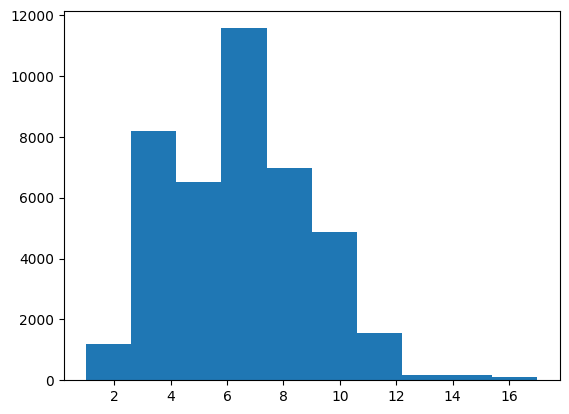

In [ ]:
slipted = [len(w.split(" ")) for w in text_title_list_final]
plt.hist(slipted)
plt.show()

In [ ]:
images_list_final[1]

'images/140008091737564223944593.jpg'

In [ ]:
TEST_SIZE = 0.15
VALIDATION_SIZE = 0.15
BATCH_SIZE = 64

##todo new dataset

# class CLIPDataset(Dataset):
#     def __init__(self, list_image_path, list_txt):
#         self.image_path = list_image_path
#         self.text = my_tokenizer(list_txt).to(device)

#     def __len__(self):
#         return len(self.text)

#     def __getitem__(self, idx):
#         image = preprocess(Image.open(self.image_path[idx]))
#         text = self.text[idx]
#         return image, text

class CLIPDataset(Dataset):
    def __init__(self, list_images, list_txt):
        self.images = list_images.to(device)
        self.text = my_tokenizer(list_txt).to(device)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        image = images[idx]
        text = self.text[idx]
        return image, text

all_df = pd.DataFrame({'text': text_title_list_final, 'image_path': images})

train_df, test_df = train_test_split(all_df, test_size=TEST_SIZE, shuffle=True, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=VALIDATION_SIZE, shuffle=True, random_state=42)

train_dataset = CLIPDataset(train_df['image_path'].tolist(), train_df['text'].tolist())
test_dataset = CLIPDataset(test_df['image_path'].tolist(), test_df['text'].tolist())
val_dataset = CLIPDataset(val_df['image_path'].tolist(), val_df['text'].tolist())

dataloader = {}
dataloader['train'] = DataLoader(train_dataset, batch_size = BATCH_SIZE)
dataloader['test'] = DataLoader(test_dataset, batch_size = BATCH_SIZE)
dataloader['val'] = DataLoader(val_dataset, batch_size = BATCH_SIZE)

# Show shape of data
for phase in ['train', 'test', 'val']:
    for item in dataloader[phase]:
        print(f'[{phase}]')
        print(f'> item[0].shape: ', item[0].shape)
        print(f'> item[1].shape: ', item[1].shape)
        break

[train]
> item[0].shape:  torch.Size([64, 3, 336, 336])
> item[1].shape:  torch.Size([64, 10])
[test]
> item[0].shape:  torch.Size([64, 3, 336, 336])
> item[1].shape:  torch.Size([64, 10])
[val]
> item[0].shape:  torch.Size([64, 3, 336, 336])
> item[1].shape:  torch.Size([64, 10])


## Fine-tune model

<div style="direction:rtl;">در این بخش قصد داریم تا مدل ساخته شده را با استفاده از دیتاست مان Fine-tune کنیم.</div>

<div style="direction:rtl;">ابتدا لازم است تا یک سری از هایپرپارامترها را در این بخش تعیین کنیم:</div>
</br>

| Hyper-paremeter                                         | Value                                               |
| ------------------------------------------------------- | --------------------------------------------------- |
| Number of Epochs [EPOCH]                                |   10                                                |
| Learning-Rate [LR]                                      |   1e-7                                              |
| Eps for Adam-optimizer [EPS]                            |   1e-9                                              |
| Weight decay of Adam-optimizer [WEIGHT_DECAY]           |   0.1                                               |
| Maximum of learning-rate value for scheduler [MAX_LR]   |   1e-2                                              |
| Optimizer                                               |   Adam                                              |
| Learning-rate scheduler [scheduler]                     |   OneCycleLR                                        |
| Image and text prediction loss                          |   CrossEntropyLoss                                  |
| Number of freeze layers                                 |   20 layer of each module (visual and transformer)  |

In [ ]:
# !mkdir /content/drive/MyDrive/clip_trained_model

In [ ]:
EPOCH = 10
LR = 1e-7
EPS = 1e-9
WEIGHT_DECAY = 0.1
MAX_LR = 1e-2
BASE_MODEL_PATH = '/content/drive/MyDrive/TasnimDataset/models/clip_trained_model/'

In [ ]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), 
                             lr=LR,
                             betas=(0.9,0.98),
                             eps=EPS,
                             weight_decay=WEIGHT_DECAY) 

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=MAX_LR, 
                                                steps_per_epoch=len(dataloader['train']), 
                                                epochs=EPOCH)

<div style="direction:rtl;">در این بخش مدل زبانی و مدل تصویر ۲۰ لایه آخر به حالت قابل آموزش هستند و بقیه مدل فریز شده است:</div>

In [ ]:
layer_num = [0, 0]
freeze_layer_thr = 30
freeze_layer_txt_thr = 20

for param in model.transformer.parameters():
    layer_num[0]+=1
for param in model.visual.parameters():
    layer_num[1]+=1

for i, param in enumerate(model.transformer.parameters()):
    if freeze_layer_txt_thr >= layer_num[0] - i:
        param.requires_grad = True
    else:
        param.requires_grad = False
for i, param in enumerate(model.visual.parameters()):
    if freeze_layer_thr >= layer_num[1] - i:
        param.requires_grad = True
    else:
        param.requires_grad = False



<div style="direction:rtl;">فرآیند آموزش به این شکل است که دارای دو فاز آموزش و اعتبار می باشد، در فاز آموزش گرادیان ها حساب شده و مراحل backpropagation انجام می شود ولی در فاز اعتبار صرفا بررسی می شود که مقدار loss چقدر است برای این داده ها، به نوعی برای مشخص کردن محلی است که مدل به اندازه کافی خوب شده است. که در این آموزش در ایپاک ۴ مدل خوب شده است.</div>

</br>

<div style="direction:rtl;">به منظور محاسبه loss در هنگام یادگیری، مطابق با <a href="https://arxiv.org/abs/2103.00020">مقاله CLIP</a> فرآیند انجام شده است:</div>

<br>

<p align="center"><img src="https://github.com/AAhmadS/NLP-HW3/blob/data/clip_train_loss.png?raw=1" width=60% /></p>

In [ ]:
def train_model(model, optimizer, scheduler, num_epochs=10):
    since = time.time()

    for epoch in range(1, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        best_val_loss = 10000000 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            total_loss = 0.0
            num = 0

            for batch in tqdm(dataloader[phase]):
                optimizer.zero_grad()
                images, texts = batch
                images = images.to(device)
                texts = texts.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    logits_per_image, logits_per_text = model(images, texts)
                    ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
                    batch_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

                    if phase == 'train':
                        batch_loss.backward()
                        optimizer.step()

                total_loss += batch_loss
                num += 1
            if phase == 'train':
                scheduler.step()

            epoch_loss = total_loss / num
            
            if phase == 'val':
              if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), BASE_MODEL_PATH+f'clip_en_fi_ep.pt')

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # if phase == 'train':
            #     torch.save(model.state_dict(), BASE_MODEL_PATH+f'clip_en_fi_ep{epoch}.pt')
            
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

In [ ]:
train_model(model=model, optimizer=optimizer, scheduler=scheduler, num_epochs=5)

Epoch 2/5
----------


  5%|▌         | 24/468 [05:21<1:39:05, 13.39s/it]


FileNotFoundError: ignored

<div style="direction:rtl;">به دلیل این که دسترسی به کولب قطع شد، ۴ ایپاک اول روی اجرای قبلی بود عکس آن ضمیمه شد.</div>
<br>

<p align="center"><img src="https://github.com/AAhmadS/NLP-HW3/blob/data/train_first_4epoch.png?raw=1" width=60% /></p>